# Geopricing with atoti
In this notebook we will explore another pricing use case combining machine learning algorithms and atoti.  
We will start by creating clusters of stores depending on their local competition and current prices, then simulate various pricing strategies with atoti.

### Dependencies
A few libraries will need to be installed for this notebook to work:  
- conda install folium  
- conda install scipy  
- conda install scikit-learn  
- conda install matplotlib  
- conda install seaborn   

## Computing stores features

### 1. Counting the number of competitor stores
We will first start by loading our stores.

In [1]:
import pandas as pd

stores_df = pd.read_csv("https://data.atoti.io/notebooks/geopricing/Store.csv", sep=";")
stores_df.head(5)

,StoresData_StoreId,StoresData_Name,StoresData_Address,StoresData_ZipCode,StoresData_City,StoresData_Region,StoresData_Country,StoresData_Latitude,StoresData_Longitude,StoresData_Company,StoresData_Open,StoreCluster
0,1,ActiveViam Store Paris 1er,Paris 1er,75001,Paris,Ile-de-France,France,48.860757,2.342566,ActiveViam,True,Aucun
1,2,ActiveViam Store Paris 15,Paris 15,75015,Paris,Ile-de-France,France,48.840412,2.312649,ActiveViam,True,Aucun
2,3,ActiveViam Store Paris 18,Paris 18,75018,Paris,Ile-de-France,France,48.886483,2.344326,ActiveViam,True,Aucun
3,4,ActiveViam Store Paris 12,Paris 12,75012,Paris,Ile-de-France,France,48.832182,2.375729,ActiveViam,True,Aucun
4,5,ActiveViam Store Paris 16,Paris 16,75016,Paris,Ile-de-France,France,48.855454,2.280886,ActiveViam,True,Aucun


And then those of the competitors.

In [2]:
competitor_stores_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/CompetitorStore.csv", sep=";"
)
competitor_stores_df.head(5)

,CompetitorStoreData_StoreId,CompetitorStoreData_Name,CompetitorStoreData_Address,CompetitorStoreData_ZipCode,CompetitorStoreData_City,CompetitorStoreData_Region,CompetitorStoreData_Country,CompetitorStoreData_Latitude,CompetitorStoreData_Longitude,CompetitorStoreData_Company,CompetitorStoreData_Open,CompetitorType
0,101,Concurrent Premium,Paris 1er,75001,Paris,Ile-de-France,France,48.860757,2.342566,Concurrent Premium,True,PREMIUM
1,102,Concurrent Premium,Paris 15,75015,Paris,Ile-de-France,France,48.840412,2.312649,Concurrent Premium,True,PREMIUM
2,103,Concurrent Premium,Paris 18,75018,Paris,Ile-de-France,France,48.886483,2.344326,Concurrent Premium,True,PREMIUM
3,104,Concurrent Premium,Paris 12,75012,Paris,Ile-de-France,France,48.832182,2.375729,Concurrent Premium,True,PREMIUM
4,105,Concurrent Premium,Paris 16,75016,Paris,Ile-de-France,France,48.855454,2.280886,Concurrent Premium,True,PREMIUM


We can already visualize on a map our stores (in green) and those of the competition.

In [3]:
from utils import utils

In [4]:
stores_map = utils.build_stores_map(competitor_stores_df, stores_df)
stores_map

To assess whether a store has strong competition or not, we will count how many competitor stores there are in an area of 1kms, 5kms, 10kms and 20kms.  
In order to to that, we first need to compute distances between stores then count the number of competitor stores for each of the kilometers values above.

### Computing distances between stores
To compute distances between stores, we simply used the [harvesine formula](https://en.wikipedia.org/wiki/Haversine_formula). Note that another approach would be to use instead something like the [google API to compute distances and durations between two points](https://developers.google.com/maps/documentation/distance-matrix/intro) (thus taking into accounts possible means of transportation).

First we build a matrix containing the distances between stores and all competitors.

In [5]:
stores_distances_matrix = utils.create_stores_distances_matrix(
    stores_df, competitor_stores_df
)
stores_distances_matrix.head()

,CompetitorStoreData_StoreId,CompetitorStoreData_Name,CompetitorStoreData_Address,CompetitorStoreData_ZipCode,CompetitorStoreData_City,CompetitorStoreData_Region,CompetitorStoreData_Country,CompetitorStoreData_Latitude,CompetitorStoreData_Longitude,CompetitorStoreData_Company,...,StoresData_ZipCode,StoresData_City,StoresData_Region,StoresData_Country,StoresData_Latitude,StoresData_Longitude,StoresData_Company,StoresData_Open,StoreCluster,Competitor distance KM
0,101,Concurrent Premium,Paris 1er,75001,Paris,Ile-de-France,France,48.860757,2.342566,Concurrent Premium,...,75001,Paris,Ile-de-France,France,48.860757,2.342566,ActiveViam,True,Aucun,0.000000
1,101,Concurrent Premium,Paris 1er,75001,Paris,Ile-de-France,France,48.860757,2.342566,Concurrent Premium,...,75015,Paris,Ile-de-France,France,48.840412,2.312649,ActiveViam,True,Aucun,3.145965
2,101,Concurrent Premium,Paris 1er,75001,Paris,Ile-de-France,France,48.860757,2.342566,Concurrent Premium,...,75018,Paris,Ile-de-France,France,48.886483,2.344326,ActiveViam,True,Aucun,2.861697
3,101,Concurrent Premium,Paris 1er,75001,Paris,Ile-de-France,France,48.860757,2.342566,Concurrent Premium,...,75012,Paris,Ile-de-France,France,48.832182,2.375729,ActiveViam,True,Aucun,3.995581
4,101,Concurrent Premium,Paris 1er,75001,Paris,Ile-de-France,France,48.860757,2.342566,Concurrent Premium,...,75016,Paris,Ile-de-France,France,48.855454,2.280886,ActiveViam,True,Aucun,4.547896


And we will use atoti to compute the number of competitors per area.

In [6]:
import atoti as tt

session = tt.create_session()

Welcome to atoti 0.4.0!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


In [7]:
distances_matrix = session.read_pandas(
    stores_distances_matrix,
    keys=["StoresData_StoreId", "CompetitorStoreData_StoreId"],
    store_name="Distances to competitor stores",
)

In [8]:
distances_cube = session.create_cube(distances_matrix, "Distances cube")

In [9]:
m = distances_cube.measures
lvl = distances_cube.levels

In [10]:
m["Competitors_1_KM"] = tt.agg.sum(
    tt.where((m["Competitor distance KM.SUM"] < 1), m["contributors.COUNT"], 0),
    scope=tt.scope.origin(
        lvl["StoresData_StoreId"], lvl["CompetitorStoreData_StoreId"]
    ),
)
m["Competitors_5_KM"] = tt.agg.sum(
    tt.where((m["Competitor distance KM.SUM"] < 5), m["contributors.COUNT"], 0),
    scope=tt.scope.origin(
        lvl["StoresData_StoreId"], lvl["CompetitorStoreData_StoreId"]
    ),
)
m["Competitors_10_KM"] = tt.agg.sum(
    tt.where((m["Competitor distance KM.SUM"] < 10), m["contributors.COUNT"], 0),
    scope=tt.scope.origin(
        lvl["StoresData_StoreId"], lvl["CompetitorStoreData_StoreId"]
    ),
)
m["Competitors_20_KM"] = tt.agg.sum(
    tt.where((m["Competitor distance KM.SUM"] < 20), m["contributors.COUNT"], 0),
    scope=tt.scope.origin(
        lvl["StoresData_StoreId"], lvl["CompetitorStoreData_StoreId"]
    ),
)

We will then use an atoti query to quickly calculate a pandas dataframe containing columns with the number of competitors in each area, and stores as rows.

In [11]:
stores_competitors_count_per_area = distances_cube.query(
    m["Competitors_1_KM"],
    m["Competitors_5_KM"],
    m["Competitors_10_KM"],
    m["Competitors_20_KM"],
    levels=[lvl["StoresData_StoreId"], lvl["StoresData_Name"]],
)
stores_competitors_count_per_area.head()

,,Competitors_1_KM,Competitors_5_KM,Competitors_10_KM,Competitors_20_KM
StoresData_StoreId,StoresData_Name,,,,
1,ActiveViam Store Paris 1er,11,51,66,71
2,ActiveViam Store Paris 15,5,46,61,71
3,ActiveViam Store Paris 18,5,36,71,71
4,ActiveViam Store Paris 12,5,31,61,71
5,ActiveViam Store Paris 16,5,36,56,71


And save this result in a file for later use

In [32]:
stores_competitors_count_per_area.to_csv(
    "FeaturesDistancesCompetitorStores.csv", index=True
)

### 2. Computing the price index per store

There are different existing formulas for the price index but the idea behind is always the same: the price index is a measurement of where a retailer is positioned compared to one or multiple of its competitors.

The formula we will use in this example compares a product price to the average price found among the local competitors of a particular store, measuring at which percentage of this average competitors price the product is.

We will weight the price index indicator by the margin when aggregating above store and product level so that we later optimize the price index for products that contribute the most to the margin.
Other commonly used formulas weight by sales quantity or revenue.

#### Price index formula:

# $100 \times \frac{\sum_{s,p \in (Stores,Products)}\frac{Selling Price(s,p)}{Average Competitor Price(s,p)} \times Margin(s,p)}{\sum_{s,p \in (Stores,Products)}Margin(s,p)}$

In [13]:
competitorPrices_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/CompetitorPrice.csv", sep=";"
)
competitorPrices_df = (
    competitorPrices_df.sort_values("AV_Date", ascending=False)
    .drop_duplicates(["AV_Id", "AV_CompetitorStoreId", "AV_Type"])
    .sort_index()
)
competition_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/Competition.csv", sep=";"
)
competitorPrices_df = pd.merge(
    competitorPrices_df,
    competition_df,
    left_on=["AV_CompetitorStoreId"],
    right_on=["AV_CompetitorStoreId"],
)
competitorPrices_store = session.read_pandas(
    competitorPrices_df,
    keys=["AV_Id", "AV_CompetitorStoreId", "AV_Type", "AV_StoreId"],
    store_name="CompetitorPricesStore",
)

The store has been sampled because there are more than 10000 lines in the files to load. Call Session.load_all_data() to trigger the full load of the data.


In [14]:
competitorStore_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/CompetitorStore.csv", sep=";"
)
competitorStore_store = session.read_pandas(
    competitorStore_df,
    keys=["CompetitorStoreData_StoreId"],
    store_name="CompetitorsStoresStore",
)

In [15]:
sellingPrices_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/SellingPrice.csv", sep=";"
)
sellingPrices_df = (
    sellingPrices_df.sort_values("AV_EndDate", ascending=False)
    .drop_duplicates(["AV_Id", "AV_StoreId", "AV_Type"])
    .sort_index()
)
sellingPrices_store = session.read_pandas(
    sellingPrices_df, keys=["AV_Id", "AV_StoreId"], store_name="SellingPricesStore"
)

In [16]:
products_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/Product.csv", sep=";"
)
products_store = session.read_pandas(
    products_df, keys=["ProductsData_Id"], store_name="ProductsStore"
)

In [17]:
stores_df = pd.read_csv("https://data.atoti.io/notebooks/geopricing/Store.csv", sep=";")
stores_store = session.read_pandas(
    stores_df, keys=["StoresData_StoreId"], store_name="StoresStore"
)

In [18]:
margin_per_product_and_store_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/margeParProduit.csv", sep=";"
)
margin_per_product_and_store = session.read_pandas(
    margin_per_product_and_store_df,
    keys=["mpp_ProductId", "mpp_StoreId"],
    store_name="margeParProduitStore",
)

In [19]:
competitorPrices_store.join(
    sellingPrices_store, mapping={"AV_Id": "AV_Id", "AV_StoreId": "AV_StoreId"}
)
competitorPrices_store.join(products_store, mapping={"AV_Id": "ProductsData_Id"})
competitorPrices_store.join(stores_store, mapping={"AV_StoreId": "StoresData_StoreId"})
competitorPrices_store.join(
    competitorStore_store,
    mapping={"AV_CompetitorStoreId": "CompetitorStoreData_StoreId"},
)
competitorPrices_store.join(
    margin_per_product_and_store,
    mapping={"AV_Id": "mpp_ProductId", "AV_StoreId": "mpp_StoreId"},
)

In [20]:
price_index_cube = session.create_cube(competitorPrices_store, "CompetitorPricesCube")

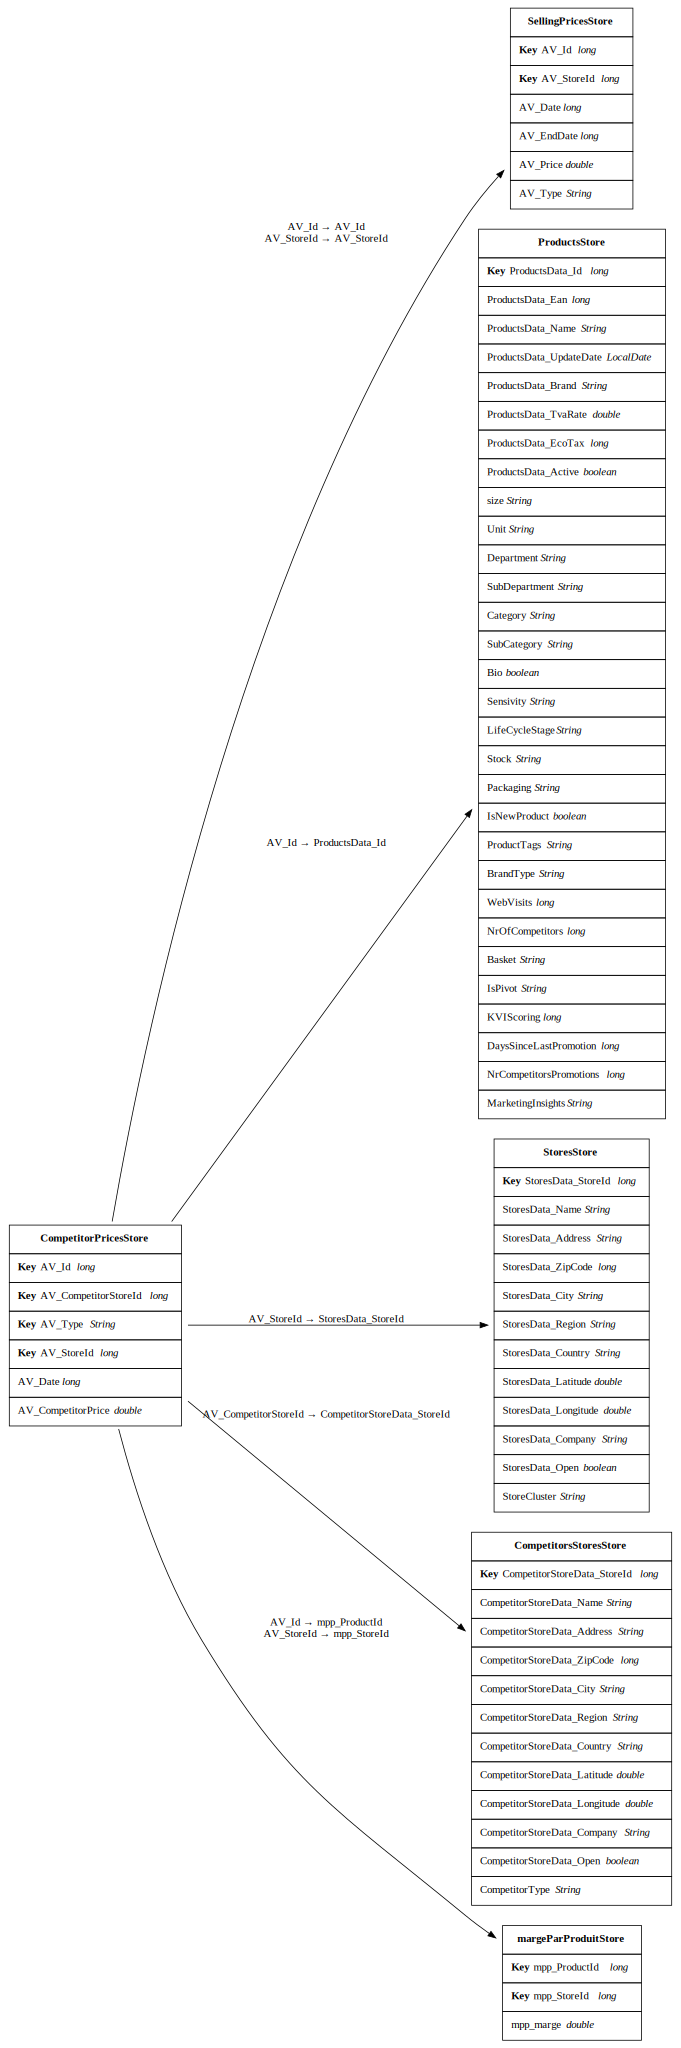

In [21]:
price_index_cube.schema

In [22]:
m = price_index_cube.measures
lvl = price_index_cube.levels

In [23]:
m["Margin.SUM"] = tt.agg.sum(margin_per_product_and_store["mpp_marge"])

In [24]:
m["Product Price"] = tt.agg.mean(sellingPrices_store["AV_Price"])

In [25]:
price_index_numerator = tt.agg.sum(
    (m["Product Price"] * m["Margin.SUM"]) / m["AV_CompetitorPrice.MEAN"],
    scope=tt.scope.origin(lvl["AV_Id"], lvl["AV_StoreId"]),
)
m["Price Index"] = price_index_numerator / m["Margin.SUM"]

We can now have the price index per store and product, let's visualize it per store.

In [27]:
session.load_all_data()
price_index_cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

#### Extracting Price index for Clustering Analysis

Using the query behind the table above, we can easily extract it to a csv.

In [28]:
mdx_price_index_per_store = """SELECT
  NON EMPTY Crossjoin(
    [Hierarchies].[AV_StoreId].[AV_StoreId].Members,
    [Hierarchies].[StoresData_Name].[StoresData_Name].Members
  ) ON ROWS,
  [Measures].[Price Index] ON COLUMNS
  FROM [CompetitorPricesCube]"""

In [29]:
price_index_per_store = session.query_mdx(mdx_price_index_per_store)
price_index_per_store.head()

,,Price Index
AV_StoreId,StoresData_Name,
1,ActiveViam Store Paris 1er,0.970508
2,ActiveViam Store Paris 15,1.020477
3,ActiveViam Store Paris 18,0.943258
4,ActiveViam Store Paris 12,0.935522
5,ActiveViam Store Paris 16,0.998487


In [33]:
price_index_per_store.to_csv("FeaturesPriceIndexPerStore.csv", index=False)

## Stores clustering using price index and competitors number features

In [34]:
%matplotlib inline
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances_argmin
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

Merging the features computed in the previous sections

In [35]:
store_distance = pd.read_csv("FeaturesDistancesCompetitorStores.csv")
store_distance.head()

,StoresData_StoreId,StoresData_Name,Competitors_1_KM,Competitors_5_KM,Competitors_10_KM,Competitors_20_KM
0,1,ActiveViam Store Paris 1er,11,51,66,71
1,2,ActiveViam Store Paris 15,5,46,61,71
2,3,ActiveViam Store Paris 18,5,36,71,71
3,4,ActiveViam Store Paris 12,5,31,61,71
4,5,ActiveViam Store Paris 16,5,36,56,71


In [36]:
store_price_index = pd.read_csv("FeaturesPriceIndexPerStore.csv")
store_price_index.head()

,Price Index
0,0.970508
1,1.020477
2,0.943258
3,0.935522
4,0.998487


Formatting the features for scikit learn

In [37]:
stores_features = pd.merge(
    store_distance,
    store_price_index[["StoresData_StoreId", "Indice prix"]],
    left_on="StoresData_StoreId",
    right_on="StoresData_StoreId",
    how="left",
)

KeyError: "None of [Index(['StoresData_StoreId', 'Indice prix'], dtype='object')] are in the [columns]"

In [38]:
stores_features_data = stores_features.set_index("StoresData_StoreId")
stores_features_data.drop(["StoresData_Name"], inplace=True, axis=1)
stores_features_data.head()

NameError: name 'stores_features' is not defined

Chosing the number of clusters

In [39]:
number_of_clusters = 5

In [40]:
kmeans = MiniBatchKMeans(number_of_clusters)
kmeans.fit(stores_features_data)
new_colors = kmeans.cluster_centers_[kmeans.predict(stores_features_data)]
k_means_labels = pairwise_distances_argmin(
    stores_features_data, kmeans.cluster_centers_
)

NameError: name 'stores_features_data' is not defined

In [41]:
plt.scatter(
    stores_features_data.loc[:, "Competitors_1_KM"],
    stores_features_data.loc[:, "Indice Prix"],
    c=k_means_labels,
    s=50,
    cmap="viridis",
);

NameError: name 'stores_features_data' is not defined